# KDD census income Prediction

###### Data Source - https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)

### Importing Required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, f1_score, classification_report, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, chi2

### Reading Data and labling Columns

In [2]:
train=pd.read_csv("census-income.csv",names =["age","class_worker","industry_code","occupation_code","education",
                                                          "wage_ph","edu_inst","marital_status","major_indu","major_occ_code","mace","hispanic_Origin",
                                                          "sex","member_of_lunion","unemp_reason","employment_stat","capital_gains","capital_losses",
                                                          "divdends_stocks","fincome_tax","region","state",
                                              "family_stat","household_sum",
                                                          "instance_wgt","migration_msa","migration_reg","migration_reg","live_status","migr_prev ",
                                                          "num_persons","fm_under_18","cb_father","cbirth_mother",
                                                          "cb_self",
                                              "citizenship","emp_stat","questionnaire","benefits","weeks_worked","year","taxable_income"
                                                          ])

#Basic text data is cleaned
train = train.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


C:\Users\palbh\Anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


### Understanding Data
#### Shape of original data - ( 199523, 42)
#### dtypes: float64(1), int64(12), object(29)
#### Target Variable - taxable_income
###### - 50000.    187141
###### 50000+.      12382
###### Name: taxable_income, dtype: int64
###### This is example of Skewed data
###### only 6% of class have 50000+ observations

In [3]:
print(train.shape) 

(199523, 42)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
age                 199523 non-null int64
class_worker        199523 non-null object
industry_code       199523 non-null int64
occupation_code     199523 non-null int64
education           199523 non-null object
wage_ph             199523 non-null int64
edu_inst            199523 non-null object
marital_status      199523 non-null object
major_indu          199523 non-null object
major_occ_code      199523 non-null object
mace                199523 non-null object
hispanic_Origin     199523 non-null object
sex                 199523 non-null object
member_of_lunion    199523 non-null object
unemp_reason        199523 non-null object
employment_stat     199523 non-null object
capital_gains       199523 non-null int64
capital_losses      199523 non-null int64
divdends_stocks     199523 non-null int64
fincome_tax         199523 non-null object
region              199523 non-null 

In [5]:
train.describe()

,age,industry_code,occupation_code,wage_ph,capital_gains,capital_losses,divdends_stocks,instance_wgt,num_persons,emp_stat,benefits,weeks_worked,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


In [6]:
train.taxable_income.value_counts()

- 50000.    187141
50000+.      12382
Name: taxable_income, dtype: int64

### Dealing With Missing Data

In [7]:
train=train.replace(['Not in universe','?','Not in universe or children','Do not know',
                    'Not in universe under 1 year old','NA'],np.nan)

In [8]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

#train.cb_self.isnull().sum()

,Missing Ratio
questionnaire,99.005628
unemp_reason,96.957744
edu_inst,93.694962
state,92.449492
migr_prev,92.094646
region,92.094646
member_of_lunion,90.445212
fm_under_18,72.288408
migration_msa,50.726984
migration_reg,50.726984


Text(0.5, 1.0, 'Percent missing data by feature')

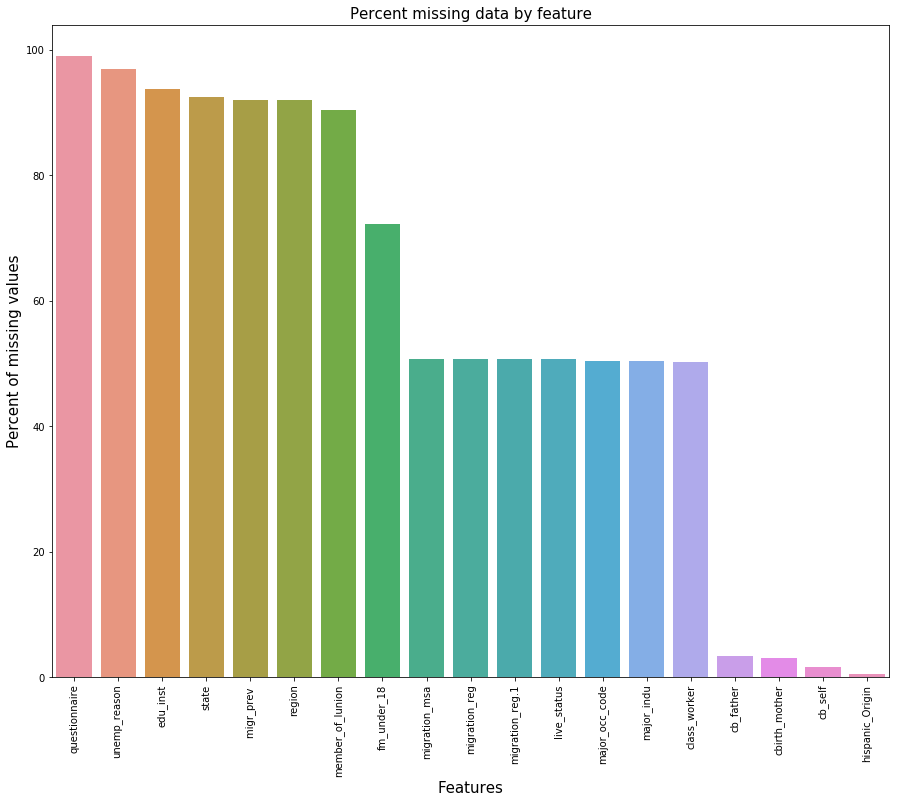

In [9]:

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index.values, y=missing_data["Missing Ratio"])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [10]:
"""
Since one cannot impute columns which have more than 50% missing values  
"""

train.drop(missing_data[missing_data['Missing Ratio']>50].index,axis=1,inplace=True)

In [11]:
train.shape

(199523, 27)

In [12]:
train.head()

,age,industry_code,occupation_code,education,wage_ph,marital_status,mace,hispanic_Origin,sex,employment_stat,...,num_persons,cb_father,cbirth_mother,cb_self,citizenship,emp_stat,benefits,weeks_worked,year,taxable_income
0,73,0,0,High school graduate,0,Widowed,White,All other,Female,Not in labor force,...,0,United-States,United-States,United-States,Native- Born in the United States,0,2,0,95,- 50000.
1,58,4,34,Some college but no degree,0,Divorced,White,All other,Male,Children or Armed Forces,...,1,United-States,United-States,United-States,Native- Born in the United States,0,2,52,94,- 50000.
2,18,0,0,10th grade,0,Never married,Asian or Pacific Islander,All other,Female,Not in labor force,...,0,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,2,0,95,- 50000.
3,9,0,0,Children,0,Never married,White,All other,Female,Children or Armed Forces,...,0,United-States,United-States,United-States,Native- Born in the United States,0,0,0,94,- 50000.
4,10,0,0,Children,0,Never married,White,All other,Female,Children or Armed Forces,...,0,United-States,United-States,United-States,Native- Born in the United States,0,0,0,94,- 50000.


In [13]:
train.columns.values

array(['age', 'industry_code', 'occupation_code', 'education', 'wage_ph',
       'marital_status', 'mace', 'hispanic_Origin', 'sex',
       'employment_stat', 'capital_gains', 'capital_losses',
       'divdends_stocks', 'fincome_tax', 'family_stat', 'household_sum',
       'instance_wgt', 'num_persons', 'cb_father', 'cbirth_mother',
       'cb_self', 'citizenship', 'emp_stat', 'benefits', 'weeks_worked',
       'year', 'taxable_income'], dtype=object)

In [14]:
train.columns[train.isnull().any()].tolist()

['hispanic_Origin', 'cb_father', 'cbirth_mother', 'cb_self']

In [14]:
# find number of missing values in cloumns
#train.isnull().any().sum()
# finding no of missing values in perticular column
#train['hispanic_Origin'].isnull().sum()
#columnwise missing values
#train.isnull().sum()

In [15]:
for column in ['hispanic_Origin', 'cb_father', 'cbirth_mother', 'cb_self']:
    train[column].fillna(train[column].mode()[0], inplace=True)

In [16]:
train.isnull().any().sum()

0

### Dealing With Outliers

C:\Users\palbh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


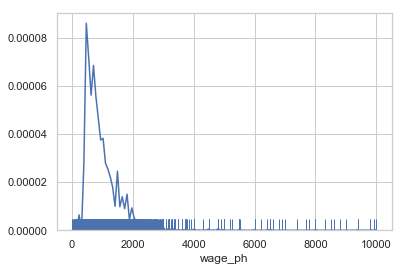

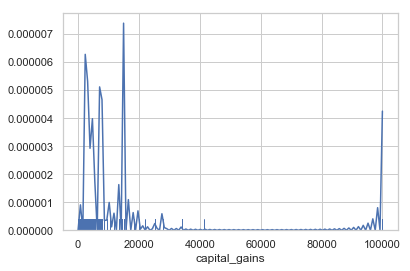

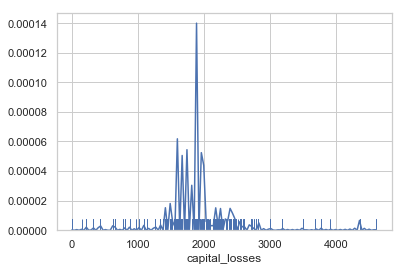

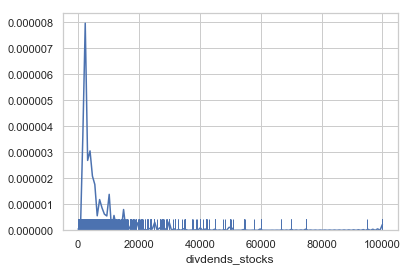

In [17]:
list1=["wage_ph","capital_gains","capital_losses","divdends_stocks"]
for i in list1:
    sns.set(style="whitegrid")
    sns.distplot(train[i], hist=False, rug=True);
    plt.show()

In [18]:
"""
Since we can see the capital_losses , capital_gains , dividends are such columns in which most of the value are 0 and only some % of data has a value in it
we can convert it into a categorical feature where if there is a value >0 we assign it 1 else keep it as zero
"""
train["cap_gain"]= np.where(train['capital_gains']>0,1, 0)
train["cap_gain"].unique()
train["cap_loss"]= np.where(train['capital_losses']>0,1, 0)
train["cap_loss"].unique()
train["dividend"]= np.where(train['divdends_stocks']>0,1, 0)
train["dividend"].unique()

array([0, 1], dtype=int64)

### Finding correlation 

In [19]:
rs = np.random.RandomState(0)
#df = pd.DataFrame(rs.rand(10, 10))
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,industry_code,occupation_code,wage_ph,capital_gains,capital_losses,divdends_stocks,instance_wgt,num_persons,emp_stat,benefits,weeks_worked,year,cap_gain,cap_loss,dividend
age,1,0.157822,0.117414,0.0369383,0.0535903,0.0633514,0.104976,-0.00161058,0.140887,-0.00226549,0.674844,0.206181,0.00441349,0.123009,0.0614086,0.238305
industry_code,0.157822,1,0.563493,0.16598,0.0660167,0.0725863,0.0127735,0.0293878,0.642096,0.252694,0.476475,0.754472,0.00342992,0.0907809,0.0760474,0.133654
occupation_code,0.117414,0.563493,1,0.194498,0.0025341,0.0436801,-0.0267262,0.0270471,0.515554,0.228952,0.43868,0.655613,-0.00313975,0.0427994,0.0479514,-0.00287159
wage_ph,0.0369383,0.16598,0.194498,1,-0.001082,0.0109931,-0.00573099,0.0123534,0.191543,0.0540515,0.113094,0.195687,0.00228285,0.015989,0.0127566,0.0233252
capital_gains,0.0535903,0.0660167,0.0025341,-0.001082,1,-0.0127001,0.131476,0.0025486,0.058015,0.0150485,0.05153,0.083549,0.00524338,0.472231,-0.0130768,0.104696
capital_losses,0.0633514,0.0725863,0.0436801,0.0109931,-0.0127001,1,0.0424272,0.00805239,0.0842554,0.0241155,0.0753911,0.100762,9.57264e-05,-0.0268938,0.97119,0.0696644
divdends_stocks,0.104976,0.0127735,-0.0267262,-0.00573099,0.131476,0.0424272,1,-9.15048e-06,0.00720631,-0.00488458,0.0545845,0.0138231,0.00191267,0.082029,0.0368074,0.28918
instance_wgt,-0.00161058,0.0293878,0.0270471,0.0123534,0.0025486,0.00805239,-9.15048e-06,1,0.042778,0.0123284,0.0405067,0.0292397,0.0117648,0.00165571,0.00869377,0.00440408
num_persons,0.140887,0.642096,0.515554,0.191543,0.058015,0.0842554,0.00720631,0.042778,1,0.240553,0.463334,0.747302,0.0187738,0.103489,0.089484,0.147922
emp_stat,-0.00226549,0.252694,0.228952,0.0540515,0.0150485,0.0241155,-0.00488458,0.0123284,0.240553,1,0.177448,0.265872,0.00737711,0.0290875,0.0254644,0.0253235


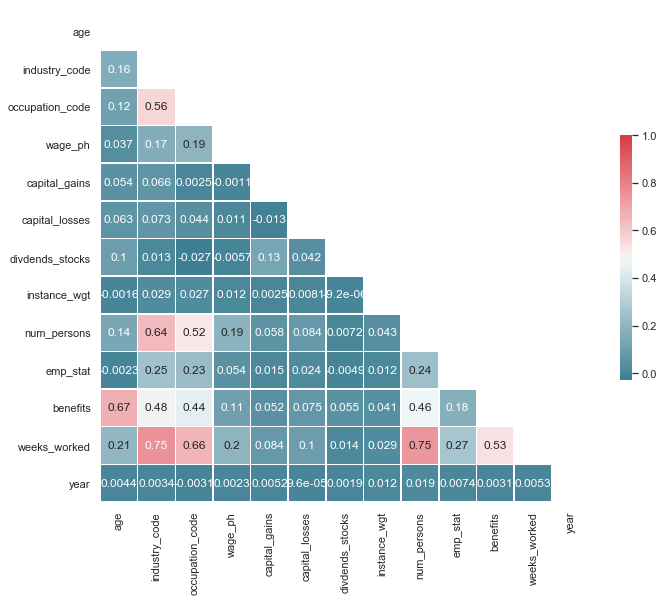

In [12]:
"""
Different color correlation plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
corr = wine_data.cor().as_data_frame()
corr.index = wine_data.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

"""



corr = train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
#print(mask)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
#Because of mask we are getting to see only one protion rather two ..
sns.heatmap(corr, mask=mask,annot=True, 
            cmap=cmap,square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5}
           )



In [59]:
train["taxable_income"].unique()

array(['- 50000.', '50000+.'], dtype=object)

Lets take a look at 'class_worker'
 Not in universe                   100245
Private                            72028
Self-employed-not incorporated      8445
Local government                    7784
State government                    4227
Self-employed-incorporated          3265
Federal government                  2925
Never worked                         439
Without pay                          165
Name: class_worker, dtype: int64


Lets take a look at the same graphically 


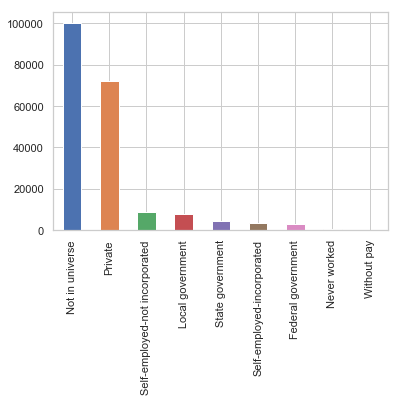

Lets take a look at 'education'
 High school graduate                      48407
Children                                  47422
Some college but no degree                27820
Bachelors degree(BA AB BS)                19865
7th and 8th grade                          8007
10th grade                                 7557
11th grade                                 6876
Masters degree(MA MS MEng MEd MSW MBA)     6541
9th grade                                  6230
Associates degree-occup /vocational        5358
Associates degree-academic program         4363
5th or 6th grade                           3277
12th grade no diploma                      2126
1st 2nd 3rd or 4th grade                   1799
Prof school degree (MD DDS DVM LLB JD)     1793
Doctorate degree(PhD EdD)                  1263
Less than 1st grade                         819
Name: education, dtype: int64


Lets take a look at the same graphically 


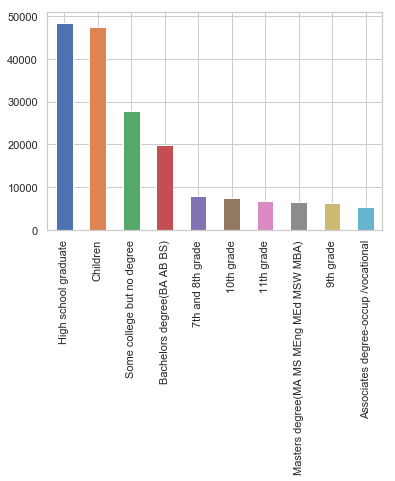

Lets take a look at 'edu_inst'
 Not in universe          186943
High school                6892
College or university      5688
Name: edu_inst, dtype: int64


Lets take a look at the same graphically 


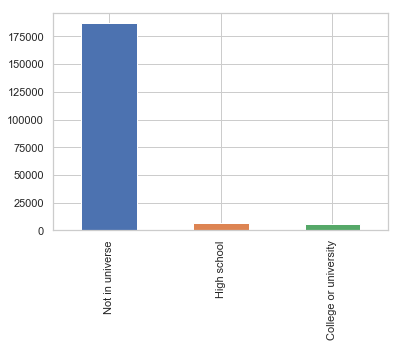

Lets take a look at 'marital_status'
 Never married                      86485
Married-civilian spouse present    84222
Divorced                           12710
Widowed                            10463
Separated                           3460
Married-spouse absent               1518
Married-A F spouse present           665
Name: marital_status, dtype: int64


Lets take a look at the same graphically 


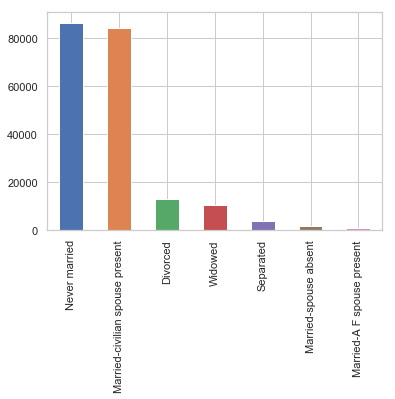

Lets take a look at 'major_indu'
 Not in universe or children            100684
Retail trade                            17070
Manufacturing-durable goods              9015
Education                                8283
Manufacturing-nondurable goods           6897
Finance insurance and real estate        6145
Construction                             5984
Business and repair services             5651
Medical except hospital                  4683
Public administration                    4610
Other professional services              4482
Transportation                           4209
Hospital services                        3964
Wholesale trade                          3596
Agriculture                              3023
Personal services except private HH      2937
Social services                          2549
Entertainment                            1651
Communications                           1181
Utilities and sanitary services          1178
Private household services                945


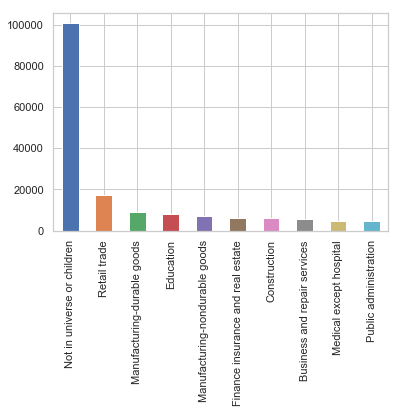

Lets take a look at 'major_occ_code'
 Not in universe                          100684
Adm support including clerical            14837
Professional specialty                    13940
Executive admin and managerial            12495
Other service                             12099
Sales                                     11783
Precision production craft & repair       10518
Machine operators assmblrs & inspctrs      6379
Handlers equip cleaners etc                4127
Transportation and material moving         4020
Farming forestry and fishing               3146
Technicians and related support            3018
Protective services                        1661
Private household services                  780
Armed Forces                                 36
Name: major_occ_code, dtype: int64


Lets take a look at the same graphically 


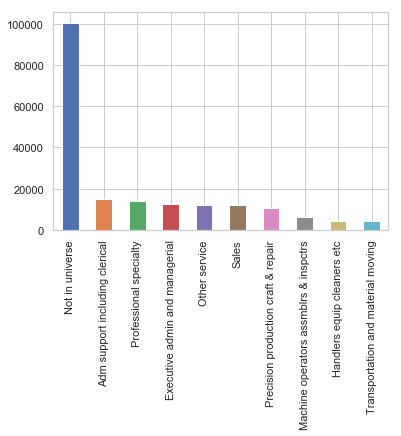

Lets take a look at 'mace'
 White                          167365
Black                           20415
Asian or Pacific Islander        5835
Other                            3657
Amer Indian Aleut or Eskimo      2251
Name: mace, dtype: int64


Lets take a look at the same graphically 


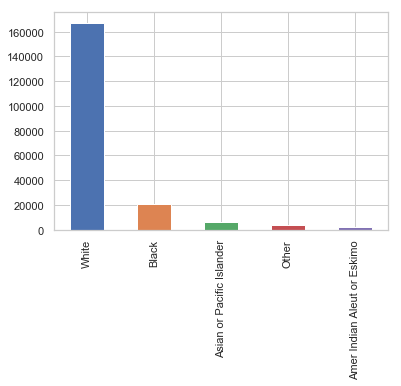

Lets take a look at 'hispanic_Origin'
 All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Cuban                          1126
NA                              874
Do not know                     306
Chicano                         304
Name: hispanic_Origin, dtype: int64


Lets take a look at the same graphically 


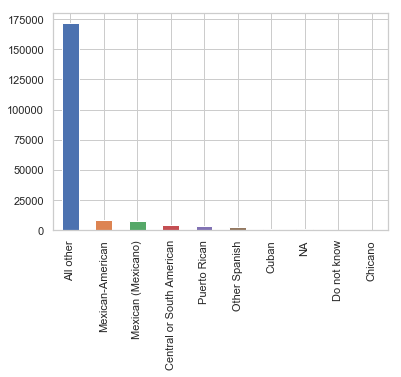

Lets take a look at 'sex'
 Female    103984
Male       95539
Name: sex, dtype: int64


Lets take a look at the same graphically 


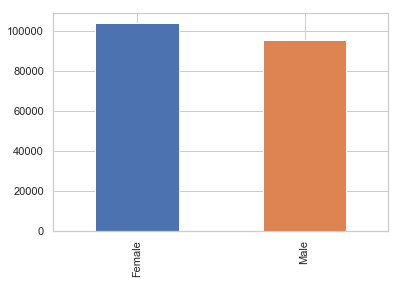

Lets take a look at 'member_of_lunion'
 Not in universe    180459
No                  16034
Yes                  3030
Name: member_of_lunion, dtype: int64


Lets take a look at the same graphically 


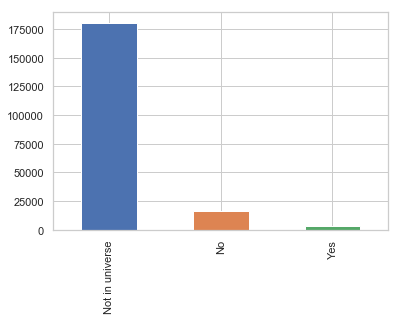

Lets take a look at 'unemp_reason'
 Not in universe          193453
Other job loser            2038
Re-entrant                 2019
Job loser - on layoff       976
Job leaver                  598
New entrant                 439
Name: unemp_reason, dtype: int64


Lets take a look at the same graphically 


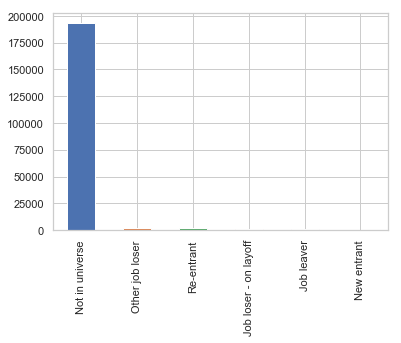

Lets take a look at 'employment_stat'
 Children or Armed Forces              123769
Full-time schedules                    40736
Not in labor force                     26808
PT for non-econ reasons usually FT      3322
Unemployed full-time                    2311
PT for econ reasons usually PT          1209
Unemployed part- time                    843
PT for econ reasons usually FT           525
Name: employment_stat, dtype: int64


Lets take a look at the same graphically 


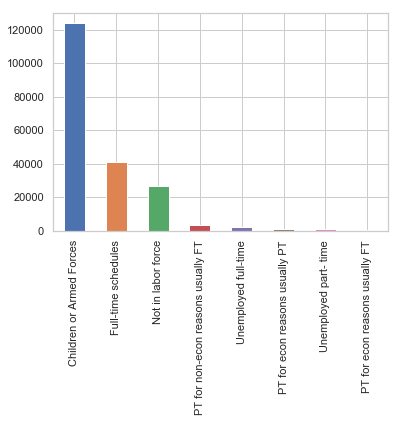

Lets take a look at 'fincome_tax'
 Nonfiler                        75094
Joint both under 65             67383
Single                          37421
Joint both 65+                   8332
Head of household                7426
Joint one under 65 & one 65+     3867
Name: fincome_tax, dtype: int64


Lets take a look at the same graphically 


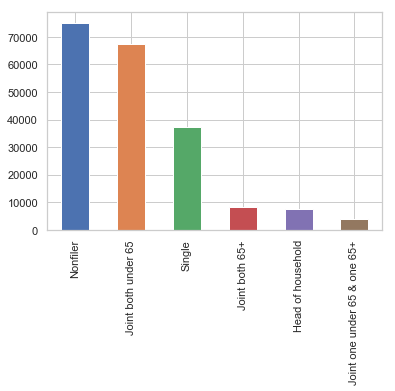

Lets take a look at 'region'
 Not in universe    183750
South                4889
West                 4074
Midwest              3575
Northeast            2705
Abroad                530
Name: region, dtype: int64


Lets take a look at the same graphically 


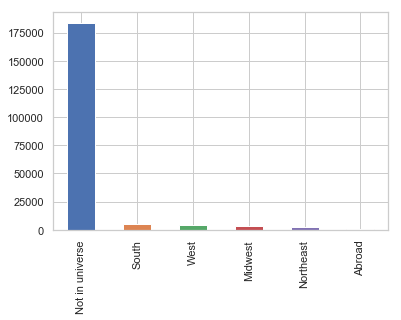

Lets take a look at 'state'
 Not in universe         183750
California                1714
Utah                      1063
Florida                    849
North Carolina             812
?                          708
Abroad                     671
Oklahoma                   626
Minnesota                  576
Indiana                    533
North Dakota               499
New Mexico                 463
Michigan                   441
Alaska                     290
Kentucky                   244
Arizona                    243
New Hampshire              242
Wyoming                    241
Colorado                   239
Oregon                     236
West Virginia              231
Georgia                    227
Montana                    226
Alabama                    216
Ohio                       211
Texas                      209
Arkansas                   205
Mississippi                204
Tennessee                  202
Pennsylvania               199
New York                   195
Louisiana 

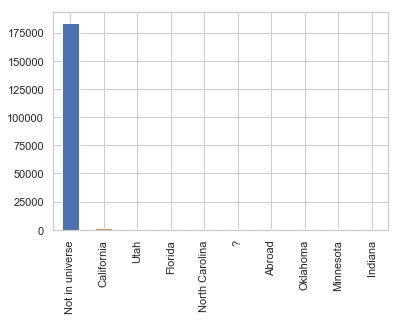

Lets take a look at 'family_stat'
 Householder                                        53248
Child <18 never marr not in subfamily              50326
Spouse of householder                              41695
Nonfamily householder                              22213
Child 18+ never marr Not in a subfamily            12030
Secondary individual                                6122
Other Rel 18+ ever marr not in subfamily            1956
Grandchild <18 never marr child of subfamily RP     1868
Other Rel 18+ never marr not in subfamily           1728
Grandchild <18 never marr not in subfamily          1066
Child 18+ ever marr Not in a subfamily              1013
Child under 18 of RP of unrel subfamily              732
RP of unrelated subfamily                            685
Child 18+ ever marr RP of subfamily                  671
Other Rel <18 never marr child of subfamily RP       656
Other Rel 18+ ever marr RP of subfamily              656
Other Rel 18+ spouse of subfamily RP                 

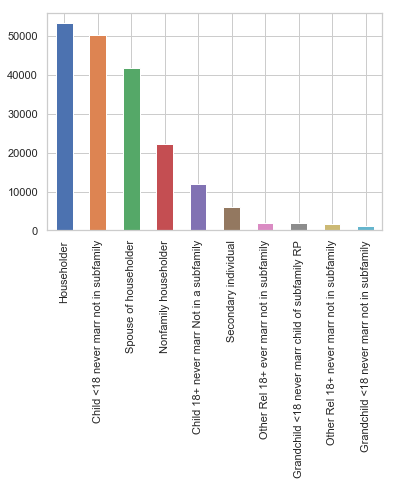

Lets take a look at 'household_sum'
 Householder                             75475
Child under 18 never married            50426
Spouse of householder                   41709
Child 18 or older                       14430
Other relative of householder            9703
Nonrelative of householder               7601
Group Quarters- Secondary individual      132
Child under 18 ever married                47
Name: household_sum, dtype: int64


Lets take a look at the same graphically 


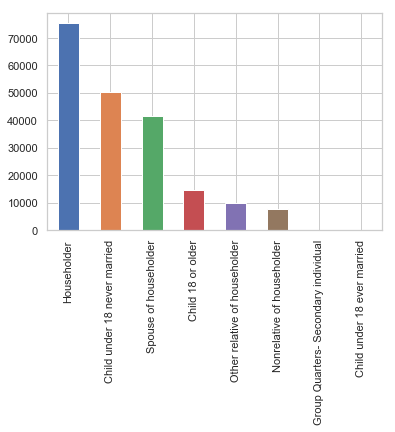

Lets take a look at 'migration_msa'
 ?                   99696
Nonmover            82538
MSA to MSA          10601
NonMSA to nonMSA     2811
Not in universe      1516
MSA to nonMSA         790
NonMSA to MSA         615
Abroad to MSA         453
Not identifiable      430
Abroad to nonMSA       73
Name: migration_msa, dtype: int64


Lets take a look at the same graphically 


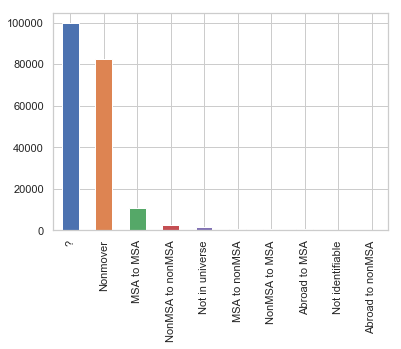

Lets take a look at 'migration_reg'
 ?                                 99696
Nonmover                          82538
Same county                        9812
Different county same state        2797
Not in universe                    1516
Different region                   1178
Different state same division       991
Abroad                              530
Different division same region      465
Name: migration_reg, dtype: int64


Lets take a look at the same graphically 


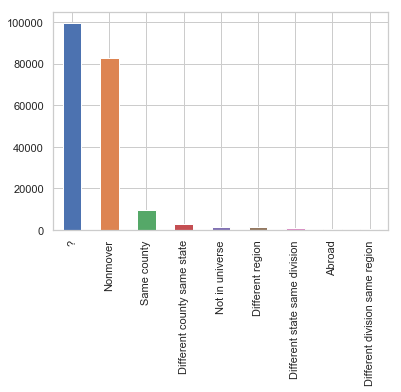

Lets take a look at 'migration_reg.1'
 ?                               99696
Nonmover                        82538
Same county                      9812
Different county same state      2797
Not in universe                  1516
Different state in South          973
Different state in West           679
Different state in Midwest        551
Abroad                            530
Different state in Northeast      431
Name: migration_reg.1, dtype: int64


Lets take a look at the same graphically 


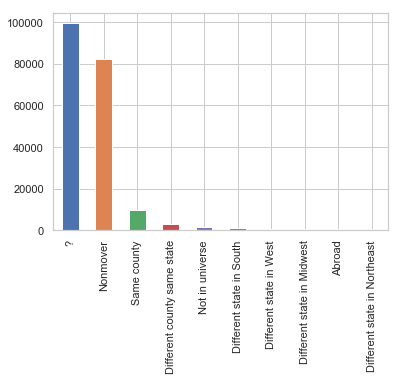

Lets take a look at 'live_status'
 Not in universe under 1 year old    101212
Yes                                  82538
No                                   15773
Name: live_status, dtype: int64


Lets take a look at the same graphically 


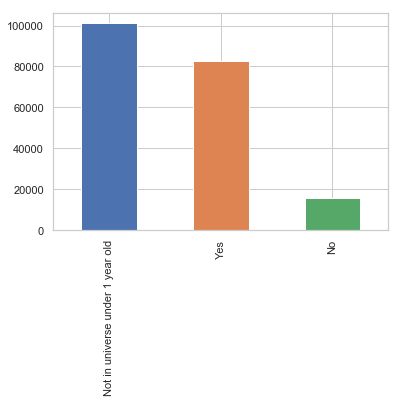

Lets take a look at 'migr_prev '
 ?                  99696
Not in universe    84054
No                  9987
Yes                 5786
Name: migr_prev , dtype: int64


Lets take a look at the same graphically 


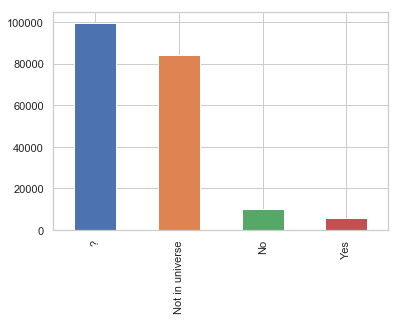

Lets take a look at 'fm_under_18'
 Not in universe           144232
Both parents present       38983
Mother only present        12772
Father only present         1883
Neither parent present      1653
Name: fm_under_18, dtype: int64


Lets take a look at the same graphically 


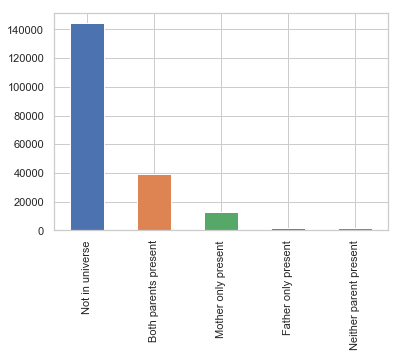

Lets take a look at 'cb_father'
 United-States                   159163
Mexico                           10008
?                                 6713
Puerto-Rico                       2680
Italy                             2212
Canada                            1380
Germany                           1356
Dominican-Republic                1290
Poland                            1212
Philippines                       1154
Cuba                              1125
El-Salvador                        982
China                              856
England                            793
Columbia                           614
India                              580
South Korea                        530
Ireland                            508
Jamaica                            463
Vietnam                            457
Guatemala                          445
Japan                              392
Portugal                           388
Ecuador                            379
Haiti                          

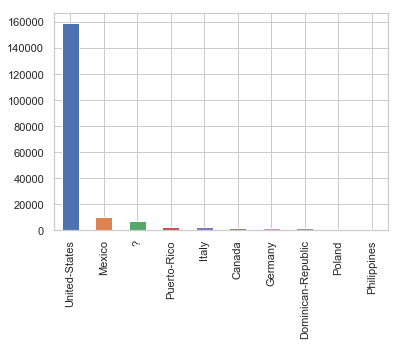

Lets take a look at 'cbirth_mother'
 United-States                   160479
Mexico                            9781
?                                 6119
Puerto-Rico                       2473
Italy                             1844
Canada                            1451
Germany                           1382
Philippines                       1231
Poland                            1110
El-Salvador                       1108
Cuba                              1108
Dominican-Republic                1103
England                            903
China                              760
Columbia                           612
South Korea                        609
Ireland                            599
India                              581
Vietnam                            473
Japan                              469
Jamaica                            453
Guatemala                          444
Ecuador                            375
Peru                               355
Haiti                      

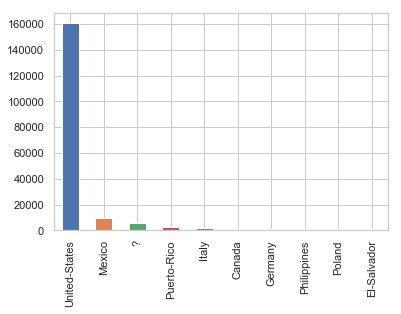

Lets take a look at 'cb_self'
 United-States                   176989
Mexico                            5767
?                                 3393
Puerto-Rico                       1400
Germany                            851
Philippines                        845
Cuba                               837
Canada                             700
Dominican-Republic                 690
El-Salvador                        689
China                              478
South Korea                        471
England                            457
Columbia                           434
Italy                              419
India                              408
Vietnam                            391
Poland                             381
Guatemala                          344
Japan                              339
Jamaica                            320
Peru                               268
Ecuador                            258
Haiti                              228
Nicaragua                        

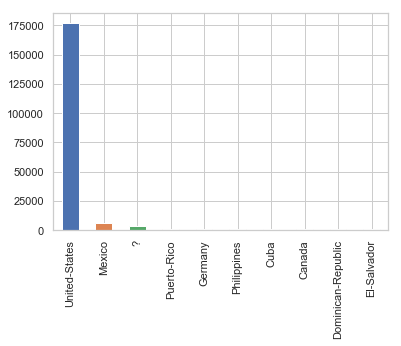

Lets take a look at 'citizenship'
 Native- Born in the United States              176992
Foreign born- Not a citizen of U S              13401
Foreign born- U S citizen by naturalization      5855
Native- Born abroad of American Parent(s)        1756
Native- Born in Puerto Rico or U S Outlying      1519
Name: citizenship, dtype: int64


Lets take a look at the same graphically 


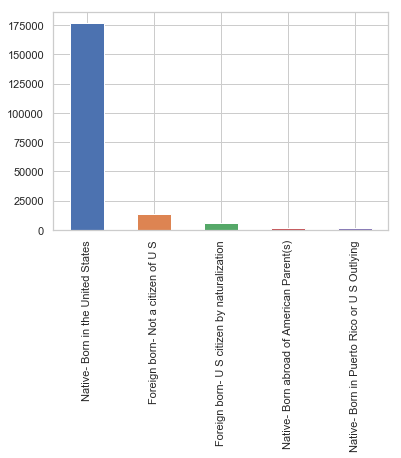

Lets take a look at 'questionnaire'
 Not in universe    197539
No                   1593
Yes                   391
Name: questionnaire, dtype: int64


Lets take a look at the same graphically 


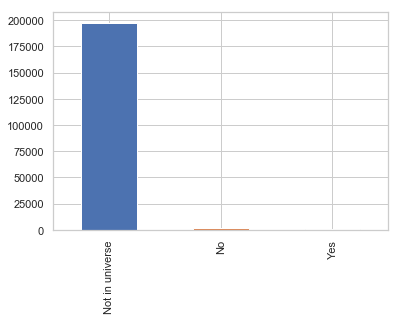

Lets take a look at 'taxable_income'
 - 50000.    187141
50000+.      12382
Name: taxable_income, dtype: int64


Lets take a look at the same graphically 


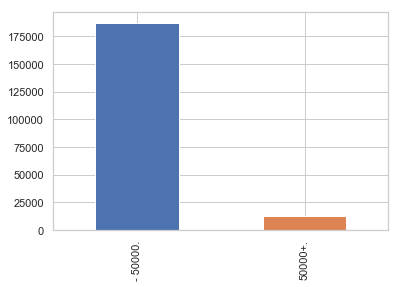

In [60]:
train_object=train.select_dtypes(include=['object'])
#train.class_worker.value_counts()

for i in train_object.columns:
    print("Lets take a look at '"+str(i)+"'\n",train[i].value_counts())
    
    print("\n")
    print("Lets take a look at the same graphically ")
    train[i].value_counts().head(10).plot.bar()
    plt.show()


In [20]:
train.taxable_income.value_counts()
#By the below count we can say that our data is highly skewed 199523

- 50000.    187141
50000+.      12382
Name: taxable_income, dtype: int64

In [21]:

train["stat"]= np.where(train['taxable_income']!='- 50000.',1, 0)

#train["taxable_income"].unique()
train["stat"].unique()

array([0, 1], dtype=int64)

Number of females : 103984
Number of males : 95539


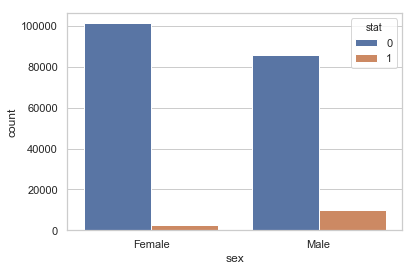

In [26]:
"""
Lets analyse how sex affect the stat as such
"""
print("Number of females :",train[train.sex=="Female"].shape[0])
print("Number of males :",train[train.sex=="Male"].shape[0])
sns.countplot(x='sex',hue='stat',data=train)
plt.show()

In [20]:
train.shape

(199523, 31)

In [22]:
train.drop(['taxable_income',"capital_gains","capital_losses","divdends_stocks"], axis=1, inplace=True)

In [23]:
a=list(train.select_dtypes(include=['object']).dtypes.index.values)

for i in a :
    # use pd.concat to join the new columns with your original dataframe
    df_xg = pd.concat([train,pd.get_dummies(train[i], prefix='cat')],axis=1)

    # now drop the original 'country' column (you don't need it anymore)
    df_xg.drop([i],axis=1, inplace=True)

### Feature Selection 

In [24]:
z=df_xg.select_dtypes(exclude=['object'])
x=z.drop(["stat"],axis=1)

y=df_xg["stat"]

#x -= x.mean(axis=0)
#x /= x.std(axis=0)

train_x, test_x, train_y, test_y=train_test_split(x, y, test_size=0.33, random_state=42)

In [25]:
y.value_counts()

0    187141
1     12382
Name: stat, dtype: int64

In [27]:
12382/(12382+187141)


0.06205800834991455

In [26]:
train_x.shape

(133680, 18)

In [28]:
test = SelectKBest(score_func=chi2, k=2)
test.fit(train_x, train_y)
scores = []
for i in range(train_x.shape[1]):
    score = test.scores_[i]
    scores.append((score, train_x.columns[i]))
        
print(sorted(scores, reverse = True))

[(236753.9927176247, 'weeks_worked'), (126826.05341088743, 'wage_ph'), (108413.08267914614, 'industry_code'), (35974.7871545114, 'age'), (19505.93836661117, 'instance_wgt'), (19028.108422667498, 'num_persons'), (8765.410446649039, 'dividend'), (6112.312358160479, 'cap_gain'), (2542.1683627739917, 'cap_loss'), (1280.7028021482056, 'benefits'), (452.1174928099376, 'occupation_code'), (409.2549577863497, 'emp_stat'), (90.43026413430411, 'cat_Foreign born- Not a citizen of U S'), (89.7282930300453, 'cat_Foreign born- U S citizen by naturalization'), (32.64499327195945, 'cat_Native- Born in Puerto Rico or U S Outlying'), (1.9551725359295484, 'cat_Native- Born abroad of American Parent(s)'), (1.6547083506953766, 'cat_Native- Born in the United States'), (0.08943844961266528, 'year')]


#### Random Forest

In [29]:
train2 = train[['weeks_worked','wage_ph','industry_code','age','instance_wgt','num_persons','dividend','cap_gain','cap_loss','benefits']]
train2.shape

(199523, 10)

In [30]:
a=list(train2.select_dtypes(include=['object']).dtypes.index.values)

for i in a :
    # use pd.concat to join the new columns with your original dataframe
    df_xg = pd.concat([train2,pd.get_dummies(train2[i], prefix='cat')],axis=1)

    # now drop the original 'country' column (you don't need it anymore)
    df_xg.drop([i],axis=1, inplace=True)

In [31]:
z=df_xg.select_dtypes(exclude=['object'])
x=z.drop(["stat"],axis=1)
y=df_xg["stat"]

#x -= x.mean(axis=0)
#x /= x.std(axis=0)

train_x, test_x, train_y, test_y=train_test_split(x, y, test_size=0.33, random_state=42,stratify=y)

In [32]:
def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier(max_depth=20,class_weight="balanced")
    clf.fit(features, target)
    return clf

In [33]:
# Train and Test dataset size details
print("Train_x Shape :: ", train_x.shape)
print("Train_y Shape :: ", train_y.shape)
print("Test_x Shape :: ", test_x.shape)
print("Test_y Shape :: ", test_y.shape)
 
# Create random forest classifier instance
trained_model = random_forest_classifier(train_x, train_y)
print("Trained model :: ", trained_model)
predictions = trained_model.predict(test_x)


Train_x Shape ::  (133680, 18)
Train_y Shape ::  (133680,)
Test_x Shape ::  (65843, 18)
Test_y Shape ::  (65843,)


C:\Users\palbh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Trained model ::  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


In [34]:

#for i in x range(0, 5):
 #   print("Actual outcome :: {} and Predicted outcome :: {}".format(list(test_y)[i], predictions[i]))

print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))
print("Precision score  :: ", precision_score(train_y, trained_model.predict(train_x)))
print("Precision score   :: ", precision_score(test_y, predictions))
print(" Confusion matrix \n", confusion_matrix(test_y, predictions))

Train Accuracy ::  0.9330640335128666
Test Accuracy  ::  0.9038925929863463
Precision score  ::  0.47959183673469385
Precision score   ::  0.34802060737527113
 Confusion matrix 
 [[56948  4809]
 [ 1519  2567]]


Accuracy: 0.9038925929863463
F1 score: 0.44791484906648055
Recall: 0.6282427802251591
Precision: 0.34802060737527113

 confussion matrix:
 [[56948  4809]
 [ 1519  2567]]


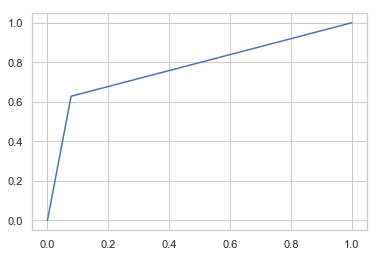

In [35]:
print('Accuracy:', accuracy_score(test_y, predictions))
print('F1 score:', f1_score(test_y, predictions))
print('Recall:', recall_score(test_y, predictions))
print('Precision:', precision_score(test_y, predictions))
print('\n confussion matrix:\n',confusion_matrix(test_y, predictions)) 

fpr,tpr,the=roc_curve(test_y, predictions)
plt.plot(fpr,tpr,)

#### XGBoost

In [36]:
model = XGBClassifier(max_depth=5,subsample = 0.8 ,n_estimators=10)
model.fit(train_x, train_y)
print(model)
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
print('Accuracy:', accuracy_score(test_y, predictions))
print('F1 score:', f1_score(test_y, predictions))
print('Recall:', recall_score(test_y, predictions))
print('Precision:', precision_score(test_y, predictions))
print('\n confussion matrix:\n',confusion_matrix(test_y, predictions)) 


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
Accuracy: 0.9432134015764774
F1 score: 0.20429878697595233
Recall: 0.11747430249632893
Precision: 0.7830342577487766

 confussion matrix:
 [[61624   133]
 [ 3606   480]]


In [37]:
scale_pos_weight = [1,2,3,4,5,6,7,8,9,10]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    clf = XGBClassifier(max_depth=10,subsample = 0.8 ,n_estimators=10,scale_pos_weight=i)
    clf.fit(train_x, train_y)
    print("Metrics on train data")
    print('--------------------')
    predict = clf.predict(train_x)
    proba = clf.predict_proba(train_x)
    cm = confusion_matrix(train_y, predict)
    print(accuracy_score(train_y, predict))
    print('Confusion Matrix: \n', cm)
    print('No : %', round(100 * (cm[0][0]/(cm[0][0]+cm[0][1]))))
    print('Yes : %', round(100* (cm[1][1]/(cm[1][0]+cm[1][1]))))
    print('F1 score:', f1_score(train_y, predict))
    
    print("Metrics on test data")
    print('--------------------')
    predict = clf.predict(test_x)
    proba = clf.predict_proba(test_x)
    cm = confusion_matrix(test_y, predict)
    print(accuracy_score(test_y, predict))
    print('Confusion Matrix: \n', cm)
    print('No : %', round(100 * (cm[0][0]/(cm[0][0]+cm[0][1]))))
    print('Yes : %', round(100* (cm[1][1]/(cm[1][0]+cm[1][1]))))
    print('F1 score:', f1_score(test_y, predict))
    

scale_pos_weight = 1: 
Metrics on train data
--------------------
0.9512941352483543
Confusion Matrix: 
 [[124411    973]
 [  5538   2758]]
No : % 99.0
Yes : % 33.0
F1 score: 0.4586347385050304
Metrics on test data
--------------------
0.94600792794982
Confusion Matrix: 
 [[61123   634]
 [ 2921  1165]]
No : % 99.0
Yes : % 29.0
F1 score: 0.3959218351741716
scale_pos_weight = 2: 
Metrics on train data
--------------------
0.9501196888090964
Confusion Matrix: 
 [[122759   2625]
 [  4043   4253]]
No : % 98.0
Yes : % 51.0
F1 score: 0.5605641228417029
Metrics on test data
--------------------
0.9420439530398068
Confusion Matrix: 
 [[60229  1528]
 [ 2288  1798]]
No : % 98.0
Yes : % 44.0
F1 score: 0.485159201295197
scale_pos_weight = 3: 
Metrics on train data
--------------------
0.9419434470377019
Confusion Matrix: 
 [[120719   4665]
 [  3096   5200]]
No : % 96.0
Yes : % 63.0
F1 score: 0.5726556907659269
Metrics on test data
--------------------
0.9323390489497745
Confusion Matrix: 
 [[59170 

#### Upsampling

In [38]:
df_majority = train[train.stat==0]
df_minority = train[train.stat==1]
print(train[train.stat==0].shape)
print(train[train.stat==1].shape)
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=80000,    # to match majority class
                                 random_state=13) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.stat.value_counts()



(187141, 27)
(12382, 27)


0    187141
1     80000
Name: stat, dtype: int64

In [39]:
80000/(187141+80000)

0.29946732250010294

In [64]:
#We can now see the ration of 0 to 1
df_upsampled.stat.value_counts()[1]/sum(df_upsampled.stat.value_counts()) #~~~ approximately equal to 3

0.29946732250010294

In [40]:
a=list(df_upsampled.select_dtypes(include=['object']).dtypes.index.values)
#cat implies category
for i in a :
    # use pd.concat to join the new columns with your original dataframe
    df_up = pd.concat([df_upsampled,pd.get_dummies(df_upsampled[i], prefix='cat')],axis=1)

    # now drop the original 'country' column (you don't need it anymore)
    df_up.drop([i],axis=1, inplace=True)

In [41]:
z=df_up.select_dtypes(exclude=['object'])
x=z.drop(["stat"],axis=1)
y=df_up["stat"]

x -= x.mean(axis=0)
x /= x.std(axis=0)

train_x, test_x, train_y, test_y=train_test_split(x, y, test_size=0.33, random_state=42)

#### Random Forest on up sampling

Train_x Shape ::  (178984, 18)
Train_y Shape ::  (178984,)
Test_x Shape ::  (88157, 18)
Test_y Shape ::  (88157,)


C:\Users\palbh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Trained model ::  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Metrics on train data
--------------------
0.9989552138738658
Confusion Matrix: 
 [[125454    135]
 [    52  53343]]
No : % 100.0
Yes : % 100.0
F1 score: 0.9982502596539817
Metrics on test data
--------------------
Accuracy: 0.9716074730310695
F1 score: 0.9545330693357069
Recall: 0.9875587295621124
Precision: 0.9236448006749631

 confussion matrix:
 [[59380  2172]
 [  331 26274]]


Text(0.5, 1.0, 'ROC curve')

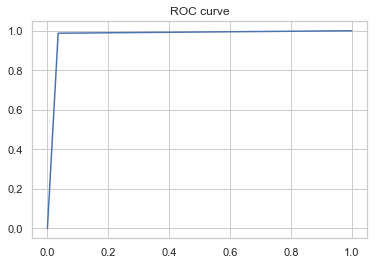

In [42]:
def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

# Train and Test dataset size details
print("Train_x Shape :: ", train_x.shape)
print("Train_y Shape :: ", train_y.shape)
print("Test_x Shape :: ", test_x.shape)
print("Test_y Shape :: ", test_y.shape)
 
# Create random forest classifier instance
trained_model = random_forest_classifier(train_x, train_y)
print("Trained model :: ", trained_model)
print("Metrics on train data")
print('--------------------')
predict = trained_model.predict(train_x)
proba = trained_model.predict_proba(train_x)
cm = confusion_matrix(train_y, predict)
print(accuracy_score(train_y, predict))
print('Confusion Matrix: \n', cm)
print('No : %', round(100 * (cm[0][0]/(cm[0][0]+cm[0][1]))))
print('Yes : %', round(100* (cm[1][1]/(cm[1][0]+cm[1][1]))))
print('F1 score:', f1_score(train_y, predict))
print("Metrics on test data")
print('--------------------')

predictions = trained_model.predict(test_x)
print('Accuracy:', accuracy_score(test_y, predictions))
print('F1 score:', f1_score(test_y, predictions))
print('Recall:', recall_score(test_y, predictions))
print('Precision:', precision_score(test_y, predictions))
print('\n confussion matrix:\n',confusion_matrix(test_y, predictions)) 

fpr,tpr,the=roc_curve(test_y, predictions)
plt.plot(fpr,tpr,)
plt.title("ROC curve")